In [1]:
import numpy as np 

In [2]:
"""The Data is taken from the following repository"""
!git clone https://github.com/liulingbo918/ATFM.git

Cloning into 'ATFM'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 20.94 MiB | 9.22 MiB/s, done.


In [3]:
"""The data consists of 3 components: in/outflow and Holidays and weather data"""
!ls ./ATFM/data/TaxiNYC/

Holiday.txt  Meteorology.h5  NYC2014.h5  README.md


In [4]:
import h5py

def read_h5(filename):
    data = {}
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())
        # Get the data
        for key in a_group_key:
            data[key] = list(f[key])
    return data

In [5]:
"""read flow data"""
flow_dir = "./ATFM/data/TaxiNYC/NYC2014.h5"
data = read_h5(flow_dir)
timeslot_data = np.array(data['date'])
flow_data = np.array(data['data'])

flow_data.shape, timeslot_data.shape

((17520, 2, 15, 5), (17520,))

In [6]:
"""read weather data"""
meteorology_data_dir = "./ATFM/data/TaxiNYC/Meteorology.h5"
meteorology_data = read_h5(meteorology_data_dir)
print(meteorology_data.keys())
temp_data = np.array(meteorology_data['Temperature'])
weather_data = np.array(meteorology_data['Weather'])
windspeed_data = np.array(meteorology_data['WindSpeed'])
date_data = np.array(meteorology_data['date'])
print(date_data.shape, weather_data.shape, windspeed_data.shape)

dict_keys(['Temperature', 'Weather', 'WindSpeed', 'date'])
(17520,) (17520, 17) (17520,)


In [7]:
"""The model architecture: https://github.com/Mouradost/ASTIR"""
import tensorflow as tf

def attention(inputs, data_format='channels_first', filters=32):
    x = tf.keras.layers.ConvLSTM2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same',
                                       data_format=data_format, return_sequences=True)(inputs)
    x = tf.keras.layers.MaxPooling3D(data_format=data_format)(x)
    x = tf.keras.layers.ConvLSTM2D(filters=filters // 2, kernel_size=(3, 3), strides=(1, 1), padding='same',
                                       data_format=data_format, return_sequences=True)(x)
    x = tf.keras.layers.UpSampling3D(data_format=data_format)(x)
    inputs_conv = tf.keras.layers.ConvLSTM2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same',
                                       data_format=data_format, return_sequences=True)(inputs)
    x = tf.keras.layers.add([x, inputs_conv])
    result = tf.keras.layers.ConvLSTM2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same',
                                       data_format=data_format, return_sequences=True)(x)
    return result


def squeeze_excite_block(input, len_seq, channel, map_height, map_width, data_format='channels_first', ratio=2, layer_count=0):
    with tf.keras.backend.name_scope('Squeeze_Block_{}'.format(layer_count)):
        init = tf.keras.layers.Reshape((len_seq*channel, map_height, map_width))(input)
        channel_axis = 1 if data_format == "channels_first" else -1
        filters = init.shape[channel_axis]
        se_shape = (1, 1, filters)

        se = tf.keras.layers.GlobalAveragePooling2D(data_format=data_format)(init)
        se = tf.keras.layers.Reshape(se_shape)(se)
        se = tf.keras.layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
        se = tf.keras.layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

        if data_format == 'channels_first':
            se = tf.keras.layers.Permute((3, 1, 2))(se)

        x = tf.keras.layers.multiply([init, se])
        x = tf.keras.layers.Reshape((len_seq, channel, map_height, map_width))(x)
    return x

def convLSTM_block(inputs, filters=32, kernel_size=(1, 1), strides=(1, 1), padding='same', data_format='channels_first', activation='tanh', dropout=0.0, l1_rec=0, l2_rec=0, l1_ker=0, l2_ker=0, l1_act=0, l2_act=0, return_sequences=True, use_bn=False):
    x = tf.keras.layers.ConvLSTM2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
                                   data_format=data_format, return_sequences=return_sequences,
                                   recurrent_regularizer=tf.keras.regularizers.l1_l2(l1=l1_rec, l2=l2_rec),
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_ker, l2=l2_ker),
                                   activity_regularizer=tf.keras.regularizers.l1_l2(l1=l1_act, l2=l2_act))(inputs)
    if use_bn:
        if data_format == 'channels_first':
            if return_sequences:
                channel_axes = 2
            else:
                channel_axes = 1
        else:
            channel_axes = -1
        x = tf.keras.layers.BatchNormalization(axis=channel_axes, scale=False)(x)
    x = tf.keras.layers.Activation(activation=activation)(x)
    if dropout > 0:
        x = tf.keras.layers.Dropout(dropout)(x)
    return x

def convLSTM_Inception_ResNet_module(inputs, layer_count, filters=32, strides=(1, 1), padding='same', data_format='channels_first', activation='tanh', types=1, dropout=0.0, l1_rec=0, l2_rec=0, l1_ker=0, l2_ker=0, l1_act=0, l2_act=0, use_bn=False, use_add_bn=True):
    with tf.keras.backend.name_scope('Inception_ResNet_ConvLSTM_Block_{}'.format(layer_count)):
        if types == 0:
            a = convLSTM_block(inputs, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            a = convLSTM_block(a, filters=filters, kernel_size=(1, 3), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            a = convLSTM_block(a, filters=filters, kernel_size=(3, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            b = convLSTM_block(inputs, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            d = tf.keras.layers.concatenate([a, b], axis=2)
            x = convLSTM_block(d, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)


        elif types == 1:
            a =convLSTM_block(inputs, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            a = convLSTM_block(a, filters=filters, kernel_size=(1, 7), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            a = convLSTM_block(a, filters=filters, kernel_size=(7, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            b = convLSTM_block(inputs, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            d = tf.keras.layers.concatenate([a, b], axis=2)
            x = convLSTM_block(d, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

        else:
            a = convLSTM_block(inputs, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            a = convLSTM_block(a, filters=filters, kernel_size=(3, 3), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            a = convLSTM_block(a, filters=filters, kernel_size=(3, 3), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            b = convLSTM_block(inputs, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            b = convLSTM_block(b, filters=filters, kernel_size=(3, 3), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            c = convLSTM_block(inputs, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

            d = tf.keras.layers.concatenate([a, b, c], axis=2)
            x = convLSTM_block(d, filters=filters, kernel_size=(1, 1), strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn)

        x = tf.keras.layers.add([x, inputs])
        if use_add_bn:
            if data_format == 'channels_first':
                channel_axes = 2
            else:
                channel_axes = -1
            x = tf.keras.layers.BatchNormalization(axis=channel_axes, scale=False)(x)
    return x


def convLSTM_Inception_ResNet_network(
    c_conf=(3, 2, 15, 5), 
    p_conf=(4, 2, 15, 5), 
    t_conf=(4, 2, 15, 5), 
    output_shape=(2, 15, 5), 
    external_shape=(28,),
    nb_modules=2,
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    data_format='channels_first',
    activation='tanh',
    dropout=0.2,
    dropout_inception_block=0,
    l1_rec=0, l2_rec=0, l1_ker=0, l2_ker=0, l1_act=0, l2_act=0, use_bn=False, use_add_bn=True,
    types=0
    ):
    inputs, outputs = [], []
    if c_conf[0] > 0 and p_conf[0] > 0 and t_conf[0] > 0:
        inputs_shape = [c_conf, p_conf, t_conf]
    if c_conf[0] == 0 and p_conf[0] > 0 and t_conf[0] > 0:
        inputs_shape = [p_conf, t_conf]
    if c_conf[0] > 0 and p_conf[0] == 0 and t_conf[0] > 0:
        inputs_shape = [c_conf, t_conf]
    if c_conf[0] > 0 and p_conf[0] > 0 and t_conf[0] == 0:
        inputs_shape = [c_conf, p_conf]
    for input_shape in inputs_shape:
        len_seq, channel, map_height, map_width = input_shape
        input_img = tf.keras.layers.Input(shape=(len_seq, channel, map_height, map_width))
        inputs.append(input_img)
        x = convLSTM_block(input_img, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=False)
        for i in range(nb_modules):
            x = convLSTM_Inception_ResNet_module(x, layer_count=i, filters=filters, strides=strides, padding=padding, dropout=dropout_inception_block,
                                                 data_format=data_format, activation=activation, types=types, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, use_bn=use_bn, use_add_bn=True)
            x = squeeze_excite_block(input=x, len_seq=len_seq, channel=filters, map_height=map_height, map_width=map_width, data_format=data_format, ratio=2, layer_count=i)
        x = convLSTM_block(x, filters=channel, kernel_size=kernel_size, strides=strides, padding=padding, data_format=data_format, activation=activation, dropout=dropout, l1_rec=l1_rec, l2_rec=l2_rec, l1_ker=l1_ker, l2_ker=l2_ker, l1_act=l1_act, l2_act=l2_act, return_sequences=False, use_bn=False)


        outputs.append(x)
    added = tf.keras.layers.add(outputs)
    if len(external_shape) != None and len(external_shape) > 0:
        external = tf.keras.layers.Input(shape=external_shape)
        inputs.append(external)
        y = tf.keras.layers.Dense(10, activation=activation)(external)
        y = tf.keras.layers.Dense(output_shape[0] * output_shape[1] * output_shape[2], activation=activation)(y)
        y = tf.keras.layers.Reshape(output_shape)(y)
        added = tf.keras.layers.add([added, y])
    if use_add_bn:
        if data_format == 'channels_first':
            channel_axes = 1
        else:
            channel_axes = -1
        added = tf.keras.layers.BatchNormalization(axis=channel_axes, scale=False)(added)
    result = tf.keras.layers.Activation(activation='tanh')(added)
    model = tf.keras.models.Model(inputs=inputs, outputs=result)

    return model

In [8]:
def load_holiday(timeslots):
    fname='./ATFM/data/TaxiNYC/Holiday.txt'
    f = open(fname, 'r')
    holidays = f.readlines()
    holidays = set([h.strip() for h in holidays])
    H = np.zeros(len(timeslots))
    for i, slot in enumerate(timeslots):
        if slot[:8] in holidays:
            H[i] = 1
    return H[:, None]

def load_meteorol(timeslots):
    fname = "./ATFM/data/TaxiNYC/Meteorology.h5"
    f = h5py.File(fname, 'r')
    Timeslot = np.array(f['date'])
    WindSpeed = np.array(f['WindSpeed'])
    Weather = np.array(f['Weather'])
    Temperature = np.array(f['Temperature'])
    f.close()

    M = dict() 
    for i, slot in enumerate(Timeslot):
        M[slot] = i

    WS = []  # WindSpeed
    WR = []  # Weather
    TE = []  # Temperature
    
    for slot in timeslots:
        predicted_id = M[slot]
        cur_id = predicted_id - 1
        WS.append(WindSpeed[cur_id])
        WR.append(Weather[cur_id])
        TE.append(Temperature[cur_id])

    WS = np.asarray(WS)
    WR = np.asarray(WR)
    TE = np.asarray(TE)

    WS = (WS - WS.min()) / (WS.max() - WS.min())
    TE = (TE - TE.min()) / (TE.max() - TE.min())
    merge_data = np.hstack([WR, WS[:, None], TE[:, None]])
    return merge_data


class STMatrix(object):
    def __init__(self, data, timestamps, T=48):
        super(STMatrix, self).__init__()
        
        self.data = data
        self.timestamps = timestamps
        self.T = T
        self.pd_timestamps = string2timestamp(timestamps, T=self.T)
        self.make_index()

    def make_index(self):
        self.get_index = dict()
        for i, ts in enumerate(self.pd_timestamps):
            self.get_index[ts] = i

    def check_complete(self):
        missing_timestamps = []
        offset = pd.DateOffset(minutes=24 * 60 // self.T)
        pd_timestamps = self.pd_timestamps
        i = 1
        while i < len(pd_timestamps):
            if pd_timestamps[i-1] + offset != pd_timestamps[i]:
                missing_timestamps.append("(%s -- %s)" % (pd_timestamps[i-1], pd_timestamps[i]))
            i += 1
        for v in missing_timestamps:
            print(v)
        assert len(missing_timestamps) == 0

    def get_matrix(self, timestamp):
        return self.data[self.get_index[timestamp]]

    def save(self, fname):
        pass

    def check_it(self, depends):
        for d in depends:
            if d not in self.get_index.keys():
                return False
        return True

    def create_dataset(self, len_closeness=3, len_trend=3, TrendInterval=7, len_period=3, PeriodInterval=1):
        offset_frame = pd.DateOffset(minutes=24 * 60 // self.T)
        XC = []
        XP = []
        XT = []
        Y = []
        timestamps_Y = []
        depends = [range(1, len_closeness+1),
                   [PeriodInterval * self.T * j for j in range(1, len_period+1)],
                   [TrendInterval * self.T * j for j in range(1, len_trend+1)]]
        i = max(self.T * TrendInterval * len_trend, self.T * PeriodInterval * len_period, len_closeness)

        while i < len(self.pd_timestamps):
            Flag = True
            for depend in depends:
                if Flag is False:
                    break
                Flag = self.check_it([self.pd_timestamps[i] - j * offset_frame for j in depend])

            if Flag is False:
                i += 1
                continue
            x_c = [self.get_matrix(self.pd_timestamps[i] - j * offset_frame) for j in depends[0]]
            x_p = [self.get_matrix(self.pd_timestamps[i] - j * offset_frame) for j in depends[1]]
            x_t = [self.get_matrix(self.pd_timestamps[i] - j * offset_frame) for j in depends[2]]
            y = self.get_matrix(self.pd_timestamps[i])
            if len_closeness > 0:
                XC.append(np.vstack(x_c))
            if len_period > 0:
                XP.append(np.vstack(x_p))
            if len_trend > 0:
                XT.append(np.vstack(x_t))
            Y.append(y)
            timestamps_Y.append(self.timestamps[i])
            i += 1
            
        XC = np.asarray(XC)
        XP = np.asarray(XP)
        XT = np.asarray(XT)
        Y = np.asarray(Y)
    
        XC = XC.reshape(XC.shape[0], int(XC.shape[1]/2), 2, XC.shape[2], XC.shape[3])
        XP = XP.reshape(XP.shape[0], int(XP.shape[1]/2), 2, XP.shape[2], XP.shape[3])
        XT = XT.reshape(XT.shape[0], int(XT.shape[1]/2), 2, XT.shape[2], XT.shape[3])
        Y = Y.reshape(Y.shape[0], 1, 2, Y.shape[2], Y.shape[3])
        return XC, XP, XT, Y, timestamps_Y



def load_data(T=48, nb_flow=2, len_closeness=None, len_period=None, 
              len_trend=None, len_test=4032):
    
    fname = "./ATFM/data/TaxiNYC/NYC2014.h5"

    data, timestamps = load_stdata(fname)
    
    data = data[:, :nb_flow]
    data[data < 0] = 0.

    mini = data.min()
    maxi = data.max()

    data = (data - mini) / (maxi - mini)
    
    XC, XP, XT = [], [], []
    Y = []

    st = STMatrix(data, timestamps, T)
    XC, XP, XT, Y, timestamps_Y = st.create_dataset(len_closeness=len_closeness, 
                                                    len_period=len_period, 
                                                    len_trend=len_trend)

    ext_feature = []
    
    # load time feature
    time_feature = timestamp2vec(timestamps_Y)
    ext_feature.append(time_feature)
    # load holiday
    holiday_feature = load_holiday(timestamps_Y)
    ext_feature.append(holiday_feature)
    # load meteorol data
    meteorol_feature = load_meteorol(timestamps_Y)
    ext_feature.append(meteorol_feature)

    if len(ext_feature) > 0:
        ext_feature = np.hstack(ext_feature)
    else:
        ext_feature = np.asarray(ext_feature) 
    
    print('time feature:', time_feature.shape)
    print('holiday feature:', holiday_feature.shape)
    print('meteorol feature: ', meteorol_feature.shape)
    print('ext feature: ', ext_feature.shape)

    XC_train = XC[:-1*len_test] 
    XP_train = XP[:-1*len_test]
    XT_train = XT[:-1*len_test]
    Y_train = Y[:-1*len_test]
    
    XC_test = XC[-1*len_test:]
    XP_test = XP[-1*len_test:]
    XT_test = XT[-1*len_test:]
    Y_test = Y[-1*len_test:]

    X_train = []
    X_test = []
    
    for X in [XC_train, XP_train, XT_train]:
        X_train.append(X)
    for X in [XC_test, XP_test, XT_test]:
        X_test.append(X)

    ext_feature_train, ext_feature_test = ext_feature[:-len_test], ext_feature[-len_test:]
    X_train.append(ext_feature_train)
    X_test.append(ext_feature_test)
    
    return X_train, Y_train, X_test, Y_test, mini, maxi
        
def load_stdata(fname):
    f = h5py.File(fname, 'r')
    data = np.array(f['data'])
    timestamps = np.array(f['date'])
    f.close()
    return data, timestamps

    
def timestamp2vec(timestamps):
    vec = [time.strptime(str(t[:8], encoding='utf-8'), '%Y%m%d').tm_wday for t in timestamps] 
    ret = []
    for i in vec:
        v = [0 for _ in range(7)]
        v[i] = 1
        if i >= 5:
            v.append(0)  # weekend
        else:
            v.append(1)  # weekday
        ret.append(v)
    return np.asarray(ret)


def string2timestamp(strings, T=48):
    timestamps = []

    time_per_slot = 24.0 / T
    num_per_T = T // 24
    for t in strings:
        year, month, day, slot = int(t[:4]), int(t[4:6]), int(t[6:8]), int(t[8:])-1
        timestamps.append(pd.Timestamp(datetime(year, month, day, hour=int(slot * time_per_slot), minute=(slot % num_per_T) * int(60.0 * time_per_slot))))

    return timestamps

In [9]:
import time
import pandas as pd
from datetime import datetime

X_train, Y_train, X_test, Y_test, mini, maxi = load_data(len_closeness=3, len_period=4, len_trend=4)

time feature: (16176, 8)
holiday feature: (16176, 1)
meteorol feature:  (16176, 19)
ext feature:  (16176, 28)


- meteorology features: temperature (1 feature), Weather (17 features) and WindSpeed (1 feature) = 19 features
- weather features: (Sunny = 0, Cloudy = 1, Overcast = 2,  Rainy = 3, Sprinkle = 4, ModerateRain = 5, HeavyRain = 6, Rainstorm = 7, Thunderstorm = 8, FreezingRain = 9, Snowy = 10,LightSnow = 11, ModerateSnow = 12, HeavySnow = 13, Foggy = 14,Sandstorm = 15, Dusty = 16) 
- holiday feature: 1 feature
- time feature: 8 features
- sum: 28

In [10]:
"""build validation data from train data"""
X_train = [X_train[0][:-960], X_train[1][:-960],X_train[2][:-960], X_train[3][:-960]]
Y_train = Y_train[:-960]
X_val = [X_train[0][-960:], X_train[1][-960:],X_train[2][-960:], X_train[3][-960:]]
Y_val = Y_train[-960:]

In [11]:
print('Train Data')
print('closeness: ', X_train[0].shape)
print('period: ', X_train[1].shape)
print('trend: ', X_train[2].shape) 
print('external: ',X_train[3].shape)
print('ext dim: ',X_train[3].shape[1])
print('labels: ',Y_train.shape)

print('Val Data')
print('closeness: ', X_val[0].shape)
print('period: ', X_val[1].shape)
print('trend: ', X_val[2].shape) 
print('external: ',X_val[3].shape)
print('ext dim: ',X_val[3].shape[1])
print('labels: ',Y_val.shape)

Train Data
closeness:  (11184, 3, 2, 15, 5)
period:  (11184, 4, 2, 15, 5)
trend:  (11184, 4, 2, 15, 5)
external:  (11184, 28)
ext dim:  28
labels:  (11184, 1, 2, 15, 5)
Val Data
closeness:  (960, 3, 2, 15, 5)
period:  (960, 4, 2, 15, 5)
trend:  (960, 4, 2, 15, 5)
external:  (960, 28)
ext dim:  28
labels:  (960, 1, 2, 15, 5)


In [12]:
model = convLSTM_Inception_ResNet_network()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
Hist = model.fit(X_train, Y_train, epochs=3, validation_data=(X_val, Y_val))

2022-02-18 13:33:48.170469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 13:33:48.271945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 13:33:48.272710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 13:33:48.274063: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/3


2022-02-18 13:35:14.801242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


350/350 [==============================] - 418s 950ms/step - loss: 0.0181 - val_loss: 0.0053
Epoch 2/3
350/350 [==============================] - 332s 949ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/3
350/350 [==============================] - 336s 959ms/step - loss: 0.0030 - val_loss: 0.0028


In [13]:
Y_preds = model.predict(X_test)
Y_preds_descaled = Y_preds * maxi
Y_test_descaled = Y_test * maxi

In [14]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true += 1
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE: ', np.sqrt(mean_squared_error(Y_test_descaled.flatten(), Y_preds_descaled.flatten())))
print('MAE: ', mean_absolute_error(Y_test_descaled.flatten(), Y_preds_descaled.flatten()))
print('MAPE: ', mean_absolute_percentage_error(Y_test_descaled.flatten(), Y_preds_descaled.flatten()), "%")

RMSE:  100.48407956956432
MAE:  59.6709060794699
MAPE:  384.8230333059763 %


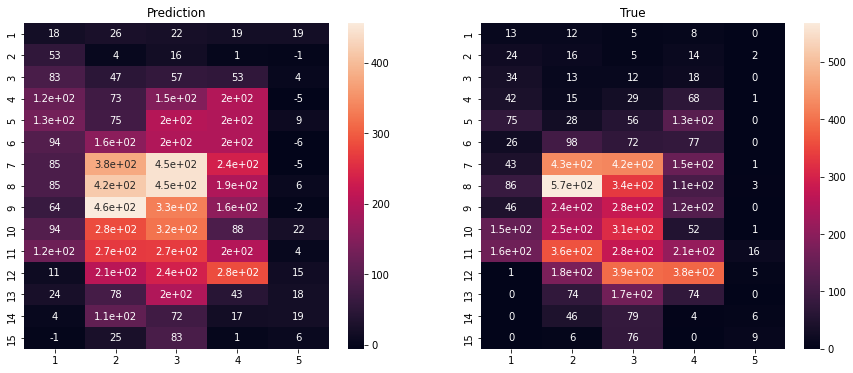

In [15]:
"""Prediction of inflow at certain time slice"""

import matplotlib.pyplot as plt
import seaborn as sns

one_time_slice_inflow_true = Y_test_descaled[0, 0, 0, :, :].reshape(15, 5)
one_time_slice_inflow_preds = Y_preds_descaled[0, 0, :, :].reshape(15, 5)
one_time_slice_inflow_preds = one_time_slice_inflow_preds.astype(int)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

y_axis_labels = range(1,16)
x_axis_labels = range(1,6)

sns.heatmap(one_time_slice_inflow_preds, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax1, annot=True)

sns.heatmap(one_time_slice_inflow_true, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax2, annot=True)

ax2.set_title('True')
ax1.set_title('Prediction')
plt.show()

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 2, 15, 5) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 2, 15, 5) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4, 2, 15, 5) 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 3, 32, 15, 5) 39296       input_1[0][0]                    
______________________________________________________________________________________________

# References:

- https://github.com/Mouradost/ASTIR
- https://github.com/jwwthu/DL4Traffic
- https://github.com/liulingbo918/ATFM